# Setup

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from fastai.imports import *
from PIL import Image
from torchvision.models import vgg16_bn
from torchvision import transforms
from ipywidgets import FileUpload

In [2]:
path = Path(r"/home/artur/Desktop/Downloads") #Adjust path accordingly
path_color = path/'c'
path_bw = path/'b'

In [3]:
bs, size= 4 ,256 #Batch size, size of images
arch = models.resnet18#Architecture with only 18 layers because running out of memory
src = ImageImageList.from_folder(path_bw).split_by_rand_pct(0.1, seed=42) #Testing data, 10% validation
num_workers = 0

In [4]:
def get_data(bs,size, num_workers = 0):
    #label_from_func means that the correct label is going to be the colored image from the color folder
    #Transforms: Zoom, horizontal flip, need more?
    data = (src.label_from_func(lambda x: path_color/x.name)
           .transform(get_transforms(max_zoom=1.2, do_flip = True), size=size, tfm_y=True)
           .databunch(bs=bs,num_workers = num_workers).normalize(imagenet_stats, do_y=True))

    data.c = 3 #Channels: Because we need 3 outputs in final layer: R, G, and B
    return data

def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=1.2), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [5]:
name_gen = 'image_gen'
data = get_data(bs, size, num_workers)
data_crit = get_crit_data([name_gen, 'color_cropped'], bs=bs, size=size)

In [6]:
#This is a pretrained model
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
#For feature loss
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [7]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [8]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
base_loss = F.l1_loss #loss function

In [9]:
wd = 1e-3
def create_gen_learner():
    return unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=False, norm_type=NormType.Weight)
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [10]:
learn_gen = create_gen_learner()
learn_crit = create_critic_learner(data_crit, metrics=None)

In [11]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.75)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [12]:
def get_concat_h(images):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    
    output = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        output.paste(im, (x_offset,0))
        x_offset += im.size[0]

    return output

def get_concat_v(images):
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    
    output = Image.new('RGB', (total_width, max_height))

    y_offset = 0
    for im in images:
        output.paste(im, (0, y_offset))
        y_offset += im.size[1]
    return output

In [13]:
def h_stitch(images):
    images_hr = []
    for img in images:
        try:
            img = pil2tensor(img,np.float32).div(255)
            p,img_hr,b = learn_gen.predict(fastai.vision.image.Image(img))
        except:
            p,img_hr,b = learn_gen.predict(img)

        img_clamped = torch.clamp(img_hr, 0, 1)
        images_hr.append(transforms.ToPILImage(mode="RGB")(img_clamped))
    combined = get_concat_h(images_hr)
    return combined

def crop_list(im, height, width):
    imgwidth, imgheight = im.size
    cropped_list = []
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            output = im.crop(box)
            cropped_list.append(output)
            
    return cropped_list, imgwidth, imgheight

def color_image(img, width = 512, height = 512):
    cropped_list, imgwidth, imgheight = crop_list(img, width, height)
    combined_list = []
    cols = imgwidth//width +1
    rows = imgheight//height
    for i in range(rows):
        combined = h_stitch(cropped_list[cols*i:cols*i + (cols)])
        combined_list.append(combined)
    output = get_concat_v(combined_list)
    output = output.crop((0,0,imgwidth, imgheight))
    return output

# App

In [14]:
learn.load('gan256-2c')

GANLearner(data=ImageDataBunch;

Train: LabelList (10 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/artur/Desktop/Downloads/b;

Valid: LabelList (1 items)
x: ImageImageList
Image (3, 256, 256)
y: ImageList
Image (3, 256, 256)
Path: /home/artur/Desktop/Downloads/b;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [15]:
uploads = FileUpload()
uploads

FileUpload(value={}, description='Upload')

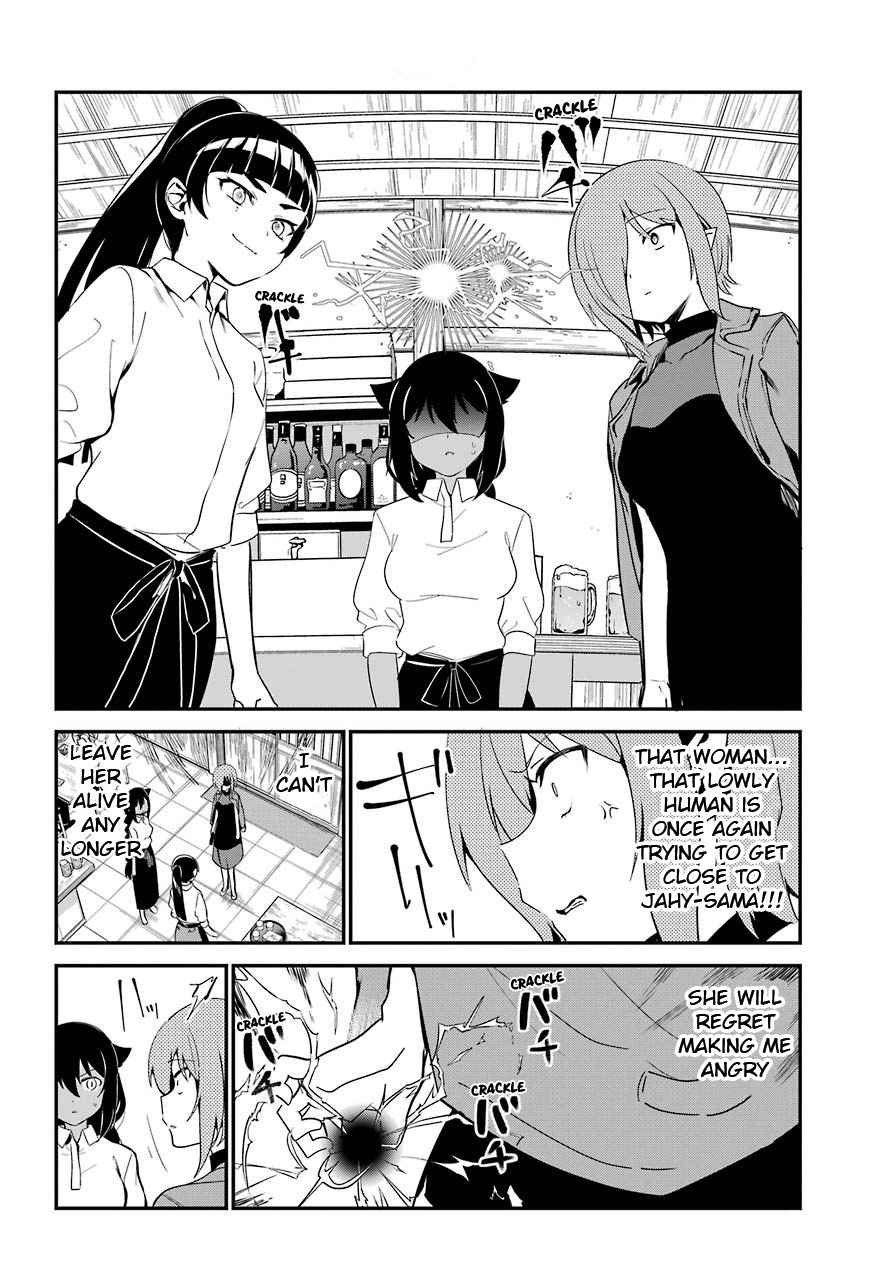

In [17]:
for name, file_info in uploads.value.items():
    img = Image.open(io.BytesIO(file_info['content']))
img

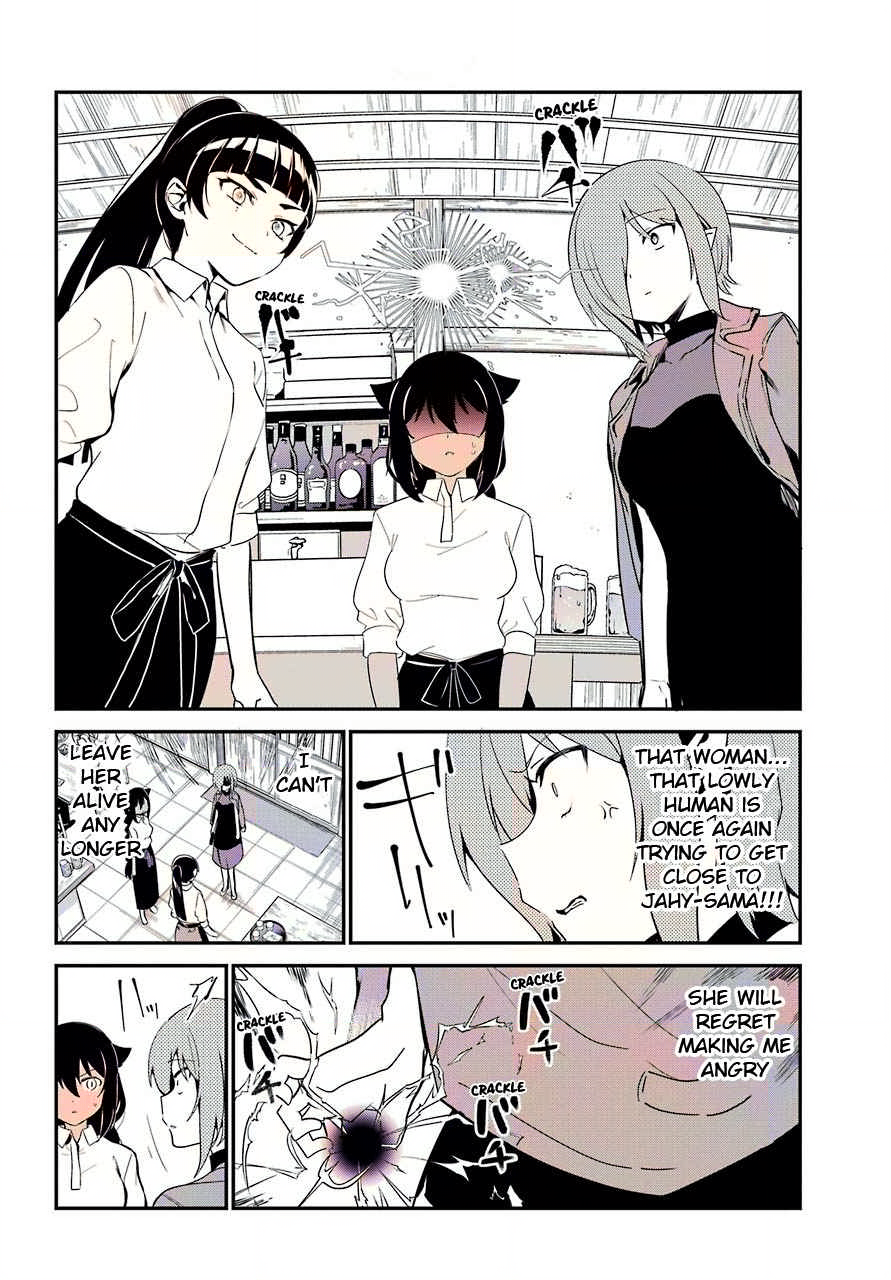

In [18]:
color_image(img, 256, 256)